# Pipeline Validation: TF-ID & YOLOv11nano

This notebook validates the vision pipeline steps:
1. **TF-ID (Florence-2)**: Detection of Figures and Tables.
2. **YOLOv11nano**: Refinement (Cut & Mask) of detected figures.

We aim to confirm that:
- Bounding boxes are accurate.
- 'Cleaned' images correctly mask labels/text while preserving data points.


In [ ]:
import os
import sys
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Add src to path
sys.path.append(os.path.abspath('../'))

from src.parsing.active_area_detector import ActiveAreaDetector
from src.parsing.yolo_detector import YoloDetector
from config import Config

# Setup Paths
pdf_name = "example.pdf"
pdf_path = os.path.join(Config.DATA_INPUT_DIR, pdf_name)
print(f"Validating pipeline for: {pdf_path}")

## Step 1: Run TF-ID (ActiveAreaDetector)

In [ ]:
# Initialize Detector
detector = ActiveAreaDetector()

# Run Detection
print("Processing PDF for detections...")
detections = detector.process_pdf(pdf_path)

# Save Crops (This is how we get the images for YOLO)
intermediate_dir = Config.DATA_INTERMEDIATE_DIR
print(f"Saving crops to {intermediate_dir}...")
saved_paths = detector.save_crops(pdf_path, detections, intermediate_dir)

tables = [p for p in saved_paths if '_table_' in p]
figures = [p for p in saved_paths if '_figure_' in p]

print(f"Found {len(tables)} tables and {len(figures)} figures.")

## Step 2: Run YOLO Refinement (Cut & Mask)

In [8]:
# Initialize YOLO
model_path = os.path.join(Config.MODELS_DIR, "best425.pt")
print(f"Loading YOLO model from: {model_path}")
yolo_detector = YoloDetector(model_path=model_path)

cleaned_figures = []
if figures:
    # We pass the list of figure image paths directly
    try:
        # The detector expects a list of paths
        cleaned_figures = yolo_detector.process_images(figures)
    except Exception as e:
        print(f"YOLO Failed: {e}")

print(f"YOLO successfully processed {len(cleaned_figures)} figures.")

Loading YOLO model from: /Users/zhaowenyuan/Projects/FlowFigTabMiner/models/best425.pt
Loading YOLO model from /Users/zhaowenyuan/Projects/FlowFigTabMiner/models/best425.pt...
   YOLO Processing: page_2_figure_0...
      -> No target_image detected. Skipping.
   YOLO Processing: page_3_figure_0...
      -> No target_image detected. Skipping.
   YOLO Processing: page_5_figure_0...
      -> Saved page_5_figure_0_t0_cleaned.png (masked 6 elements)
   YOLO Processing: page_5_figure_1...
      -> Saved page_5_figure_1_t0_cleaned.png (masked 8 elements)
   YOLO Processing: page_6_figure_0...
      -> Saved page_6_figure_0_t0_cleaned.png (masked 6 elements)
   YOLO Processing: page_6_figure_1...
      -> Saved page_6_figure_1_t0_cleaned.png (masked 6 elements)
   YOLO Processing: page_7_figure_1...
      -> Saved page_7_figure_1_t0_cleaned.png (masked 3 elements)
YOLO successfully processed 5 figures.


## Step 3: Visualization

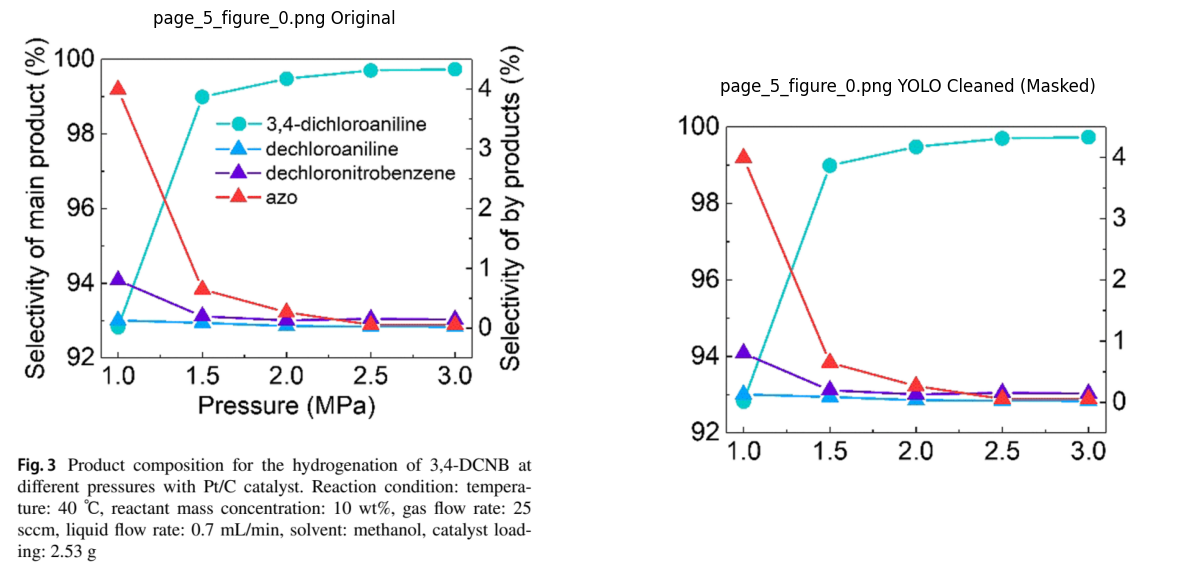

Elements found in page_5_figure_0.png: ['x_axis_title', 'legend', 'y_axis_title']


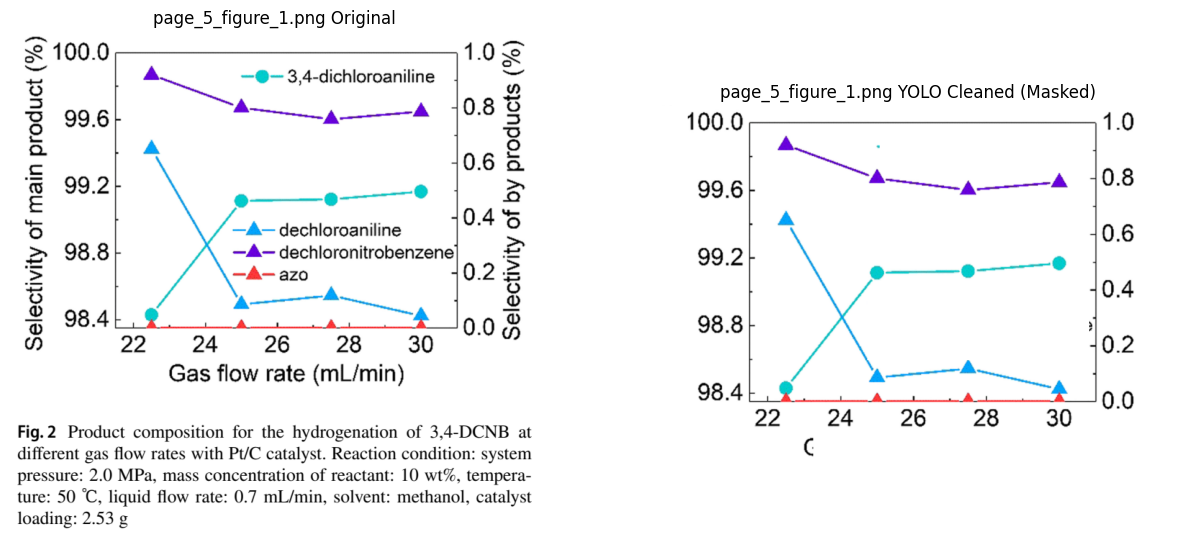

Elements found in page_5_figure_1.png: ['x_axis_title', 'y_axis_title', 'legend']


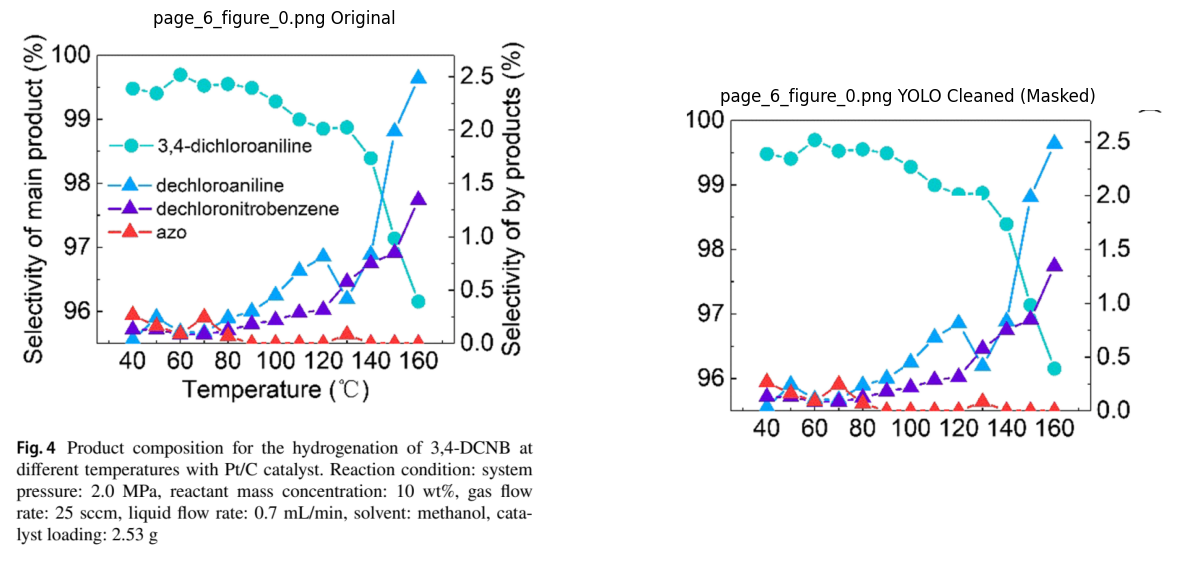

Elements found in page_6_figure_0.png: ['y_axis_title', 'legend', 'x_axis_title']


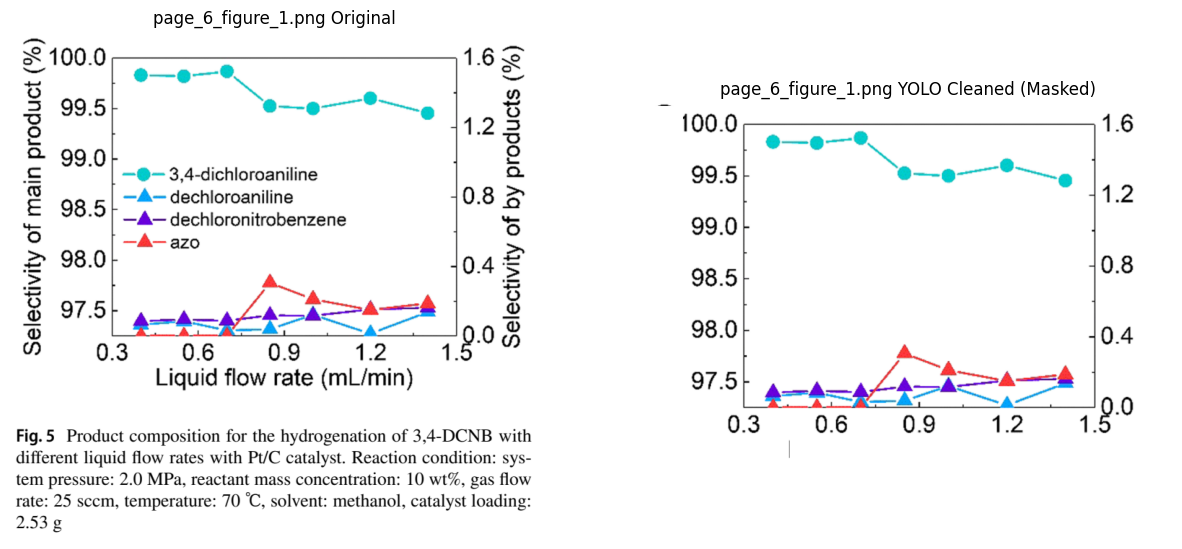

Elements found in page_6_figure_1.png: ['legend', 'x_axis_title', 'y_axis_title']


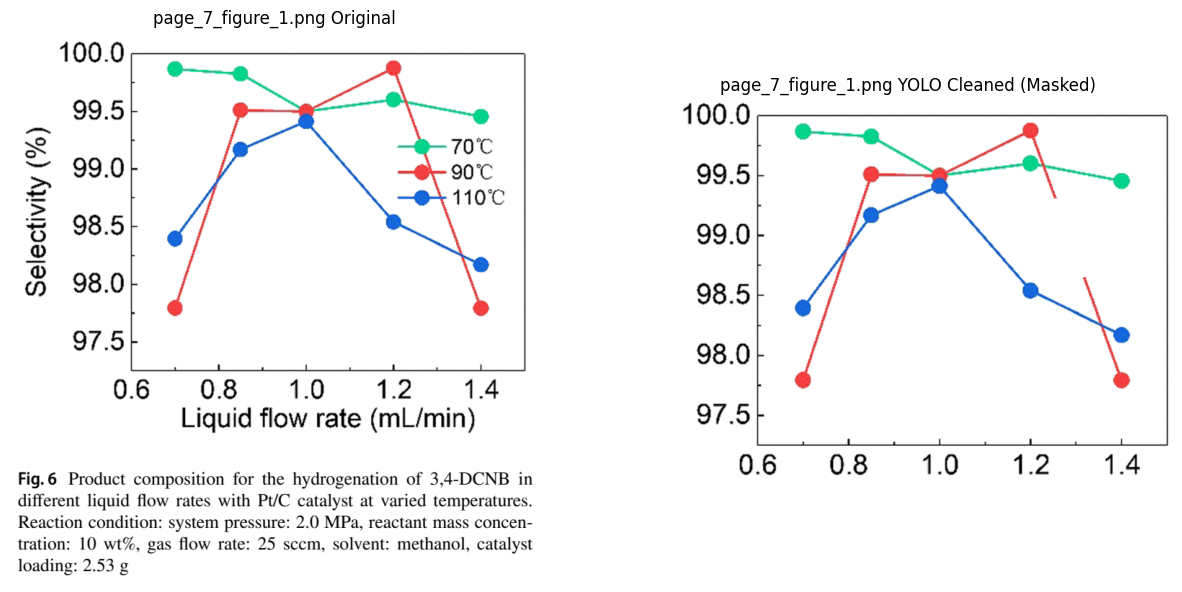

Elements found in page_7_figure_1.png: ['legend', 'y_axis_title', 'x_axis_title']


In [9]:
def show_side_by_side(original_path, cleaned_path, title_prefix=""):
    if not os.path.exists(original_path) or not os.path.exists(cleaned_path):
        print(f"Missing file(s): {original_path} or {cleaned_path}")
        return
        
    orig = Image.open(original_path)
    clean = Image.open(cleaned_path)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    axes[0].imshow(orig)
    axes[0].set_title(f"{title_prefix} Original")
    axes[0].axis('off')
    
    axes[1].imshow(clean)
    axes[1].set_title(f"{title_prefix} YOLO Cleaned (Masked)")
    axes[1].axis('off')
    plt.show()

# Visualize Results
if not cleaned_figures:
    print("No cleaned figures to display.")
else:
    for item in cleaned_figures:
        # item contains: {original_source, cleaned_image, elements}
        orig_path = item.get('original_source')
        clean_path = item['cleaned_image']
        
        title = os.path.basename(orig_path) if orig_path else "Unknown"
        show_side_by_side(orig_path, clean_path, title_prefix=title)
        
        # Also visualize extracted crops if available
        if 'elements' in item and item['elements']:
            print(f"Elements found in {title}: {list(item['elements'].keys())}")
